# Feature Engineering 

## 1) clean and compress categotical features where needed
## 2) use Variance Inflation Factor to select features
## 3) Check feature correlation with heatmap
## 4) use Predictive Power Score to asses features relation to Mean Scale Score

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('../../data/by_student_group/grocery_added.csv',low_memory=False)

df.drop(columns=['Unnamed: 0','National School Lunch Program [Public School] 2020-21','School Type [Public School] 2020-21',
                'County Name_y','District Name_y', 'School Name_y','CDS',"No. of Service Days Req'd"],inplace=True)
df.rename(columns ={'County Name_x':'County_Name','District Name_x':'District_Name',
                    'Lowest Grade Offered [Public School] 2020-21':'Lowest Grade Offered',
                    'School Name_x':'School_Name',
'Total Students, All Grades (Excludes AE) [Public School] 2020-21':'Total_Students(No-AE)',
'Total Students, All Grades (Includes AE) [Public School] 2020-21':'Total_Students(With-AE)',
'Grades 1-8 Students [Public School] 2020-21':'1-8th_Students',
    'Pupil/Teacher Ratio [Public School] 2020-21':'Pupil/Teacher-Ratio',
       'Grades 9-12 Students [Public School] 2020-21':'9-12_Students',
        'Full-Time Equivalent (FTE) Teachers [Public School] 2020-21':'FTE_Teachers',
                    'Hispanic - male [Public School] 2020-21':'Hispanic_Male',
       'Hispanic - female [Public School] 2020-21':'Hispanic_Female',
       'Black or African American - male [Public School] 2020-21':'Black_or_AA_M',
       'Black or African American - female [Public School] 2020-21':'Black_or_AA_F'}
          ,inplace=True)
df.shape

(316683, 95)

In [5]:
## get only 11th grade scores 
dfe= df[df['Grade']==11].copy()
dfe.shape

(56794, 95)

# 1
## Convert data types and map small categotical values togeather to prep for one hot encoding

In [6]:
dfe['Charter_School'] = np.where(dfe['Charter_School']=='N',0,1)
dfe['Charter_School'].value_counts()

0    42771
1    14023
Name: Charter_School, dtype: int64

In [7]:

dfe['Education_type'] = pd.Series(dfe['Education_type'], dtype="string")

In [8]:
dfe['Education_type'] = dfe['Education_type'].replace({
                                                   'Community Day School':'other',
                                                   'Opportunity School':'other',
                                                 'Youth Authority School':'other',
                                                  'Special Education School':'other'})

In [9]:
dfe['Education_type'].value_counts()

Traditional                     44569
Continuation School              4385
Alternative School of Choice     2867
County Community School           626
other                             302
Juvenile Court School             300
Name: Education_type, dtype: int64

In [10]:
dfe['Demographic Name'].value_counts()

Hispanic or Latino                                                  5588
White                                                               3346
All Students                                                        2716
Not armed forces family member                                      2715
Not migrant education                                               2712
Not homeless                                                        2688
IFEP and EO (Initial fluent English proficient and English only)    2657
No reported disabilities                                            2640
Economically disadvantaged                                          2383
Male                                                                2375
EO (English only)                                                   2317
Female                                                              2250
Ever�EL                                                             2049
Not economically disadvantaged                     

In [11]:
dfe['Demographic Name'] = dfe['Demographic Name'].replace({'Native Hawaiian or Pacific Islander':'Asian'})

## need to drop small groups Migrant education

dfe.drop(dfe[dfe['Demographic Name']=='Migrant education'].index,axis=0,inplace=True)
dfe.drop(dfe[dfe['Demographic Name']=='ELs enrolled less than 12 months'].index,axis=0,inplace=True)
dfe.drop(dfe[dfe['Demographic Name']=='American Indian or Alaska Native'].index,axis=0,inplace=True)

In [12]:
 dfe['Low Grade'] =  dfe['Low Grade'].replace(
 {'8':'11 or 8','5':'5,4,3,2,1','4':'5,4,3,2,1','3':'5,4,3,2,1',
  '1':'5,4,3,2,1','2':'5,4,3,2,1','11':'11 or 8'})
dfe['Low Grade'] =pd.Series( dfe['Low Grade'], dtype="string")

In [13]:
 dfe['Low Grade'].value_counts()

9            42838
K             6634
6             2297
7             1968
P             1574
10             524
11 or 8        361
5,4,3,2,1      326
Name: Low Grade, dtype: Int64

In [14]:
dfe['Zip_Code'] = pd.Series(dfe['Zip_Code'], dtype="string")
dfe['Zip_Code'].sample(5)
print(dfe.Zip_Code.dtypes)

string


In [13]:

def calculate_vif(df, features):   
    from sklearn.linear_model import LinearRegression
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

In [15]:
df['Test ID'].value_counts()

Mathematics                       160303
English Language Arts/Literacy    156380
Name: Test ID, dtype: int64

In [16]:
model_df = dfe[[
    # categorical features
    'County_Name', 'District_Name', 'School_Name', 'Zip_Code',
   'Demographic Name', 'Student Group','District Type','Test ID',
       'School Type', 'Education_type', 'Charter_School',  'Low Grade',
    # target y
    'Mean Scale Score',
    # continuous features 
    'Total Tested at Reporting Level',
       'Total Tested with Scores at Reporting Level',
               'Students Enrolled', 'Students Tested', 
    
    ## aggregates of scores would give data leakage can not use 
    
#        'Percentage Standard Exceeded', 'Percentage Standard Met',
#        'Percentage Standard Met and Above', 'Percentage Standard Nearly Met',
#        'Percentage Standard Not Met',
    
    
    'Students with Scores', 
       'Enrollment', 'Free_Meal_count', 'Percent_Eligible',
       'FRPM_Count', 'Percent_Eligible_FRPM',
       'Free_Meal_Count', 'Percent_Eligible_Free', 
         'Latitude', 'Longitude',
       '9-12_Students',
       'FTE_Teachers', 'Pupil/Teacher-Ratio', 'Hispanic_Male',
       'Hispanic_Female', 'Black_or_AA_M', 'Black_or_AA_F',
       'Asian or Asian/Pacific Islander - male [Public School] 2020-21',
       'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
                'Avg_21',
        'Total Salary Schedule FTE', 'Lowest Salary Offered',
       'Average Salary Paid', 'Highest Entry Level Step',
       'Highest Salary Offered', 'Salary at BA+60 Step 10', '2020–21 P‑2 ADA',
       '% Salary Change Over 2019–20', 'EDP 365', 'Current\nExpense ADA',
       'Current\nExpense Per ADA', 'Estimated Total Population',
       'Estimated Population 5-17', 'est_num_u17_pov', 'Grocery_3mile',
       'Grocery_dist'
               ]].copy()

In [17]:
model_df['District Type'] =model_df['District Type'].replace({
    'State Board of Education':'other','Non-School Locations':'other'})

model_df['Education_type'] = model_df['Education_type'].replace({
   'Community Day School':'other','Opportunity School':'other',
    'Youth Authority School':'other','Special Education School':'other'
})

In [17]:
model_df['Education_type'].value_counts()

Traditional                     44486
Continuation School              4385
Alternative School of Choice     2867
County Community School           626
other                             302
Juvenile Court School             300
Name: Education_type, dtype: int64

In [18]:
model_df['District Type'].value_counts()

Unified School District             38866
High School District                13006
County Office of Education (COE)     2545
Elementary School District           1822
other                                 283
Name: District Type, dtype: int64

In [18]:
numeric = ['Mean Scale Score',
    'Total Tested at Reporting Level',
           'Zip_Code',
       'Total Tested with Scores at Reporting Level',
               'Students Enrolled', 'Students Tested', 
        'Students with Scores', 
       'Enrollment', 'Free_Meal_count', 'Percent_Eligible',
       'FRPM_Count', 'Percent_Eligible_FRPM',
       'Free_Meal_Count', 'Percent_Eligible_Free', 
         'Latitude', 'Longitude',
       '9-12_Students',
       'FTE_Teachers', 'Pupil/Teacher-Ratio', 'Hispanic_Male',
       'Hispanic_Female', 'Black_or_AA_M', 'Black_or_AA_F',
       'Asian or Asian/Pacific Islander - male [Public School] 2020-21',
       'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
                'Avg_21',
        'Total Salary Schedule FTE', 'Lowest Salary Offered',
       'Average Salary Paid', 'Highest Entry Level Step',
       'Highest Salary Offered', 'Salary at BA+60 Step 10', '2020–21 P‑2 ADA',
       '% Salary Change Over 2019–20', 'EDP 365', 'Current\nExpense ADA',
       'Current\nExpense Per ADA', 'Estimated Total Population',
       'Estimated Population 5-17', 'est_num_u17_pov', 'Grocery_3mile',
       'Grocery_dist']

In [19]:
model_df[numeric]= model_df[numeric].apply(pd.to_numeric,errors='coerce')

## Check for nulls to clean 

In [20]:
m = pd.DataFrame([model_df.isnull().sum(),100*model_df.isnull().mean()])
m = m.T
m.columns=['count', '%']
m = m.sort_values(by='count',ascending=False)
m.head(25)

,count,%
Black_or_AA_F,16317.0,28.781839
Asian or Asian/Pacific Islander - female [Public School] 2020-21,15874.0,28.000423
Black_or_AA_M,15817.0,27.899880
Asian or Asian/Pacific Islander - male [Public School] 2020-21,15581.0,27.483596
Pupil/Teacher-Ratio,13304.0,23.467156
Hispanic_Female,13260.0,23.389543
Hispanic_Male,13260.0,23.389543
9-12_Students,13260.0,23.389543
FTE_Teachers,13179.0,23.246666
Longitude,12999.0,22.929161


## Impute nulls with district then county averages for numeric columns nulls 

In [21]:
cols = model_df[numeric].columns.values
for i in cols:
    model_df[i] = model_df[i].fillna(model_df.groupby(['District_Name'])[i].transform('mean'))
for i in cols:
    model_df[i] = model_df[i].fillna(model_df.groupby(['County_Name'])[i].transform('mean'))


In [22]:
m = pd.DataFrame([model_df.isnull().sum(),100*model_df.isnull().mean()])
m = m.T
m.columns=['count', '%']
m = m.sort_values(by='count',ascending=False)
m.head(20)

,count,%
School Type,3726.0,6.572356
Education_type,3726.0,6.572356
School_Name,3556.0,6.272490
Black_or_AA_M,273.0,0.481549
Black_or_AA_F,266.0,0.469202
District Type,170.0,0.299866
Low Grade,170.0,0.299866
Asian or Asian/Pacific Islander - male [Public School] 2020-21,99.0,0.174628
Longitude,81.0,0.142877
Hispanic_Male,81.0,0.142877


In [23]:
## the all name blanks were probably the county averages 

## drop nulls 

print(model_df.shape)
model_df = model_df.dropna(how='any',axis=0)
model_df.shape

(56692, 53)


(52665, 53)

In [24]:
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [25]:
m = pd.DataFrame([model_df.isnull().sum(),100*model_df.isnull().mean()])
m = m.T
m.columns=['count', '%']
m = m.sort_values(by='count',ascending=False)
m.head(5)

,count,%
County_Name,0.0,0.0
9-12_Students,0.0,0.0
Pupil/Teacher-Ratio,0.0,0.0
Hispanic_Male,0.0,0.0
Hispanic_Female,0.0,0.0


# 2
## Use numerical columns to calculate Variance Inflaciton Factor (VIF)

In [28]:

vifs = ['Total Tested with Scores at Reporting Level',
'Free_Meal_count',
     'Zip_Code',
     'Latitude', 
               'Longitude',
       '9-12_Students', 
               'FTE_Teachers', 
               'Pupil/Teacher-Ratio', 
       'Hispanic_Female',
               'Black_or_AA_F',
       'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
       'Avg_21',
       'Average Salary Paid', 
       'Highest Salary Offered', 
       '% Salary Change Over 2019–20',
               'EDP 365',
       'Current\nExpense Per ADA', 
               'Estimated Total Population',
 'est_num_u17_pov', 'Grocery_3mile',
       'Grocery_dist']

In [29]:
vif_df= calculate_vif(model_df[vifs],model_df[vifs].columns.values)
vif_df

,VIF,Tolerance
Total Tested with Scores at Reporting Level,1.156885,0.864390
Free_Meal_count,2.355629,0.424515
Zip_Code,8.280288,0.120769
Latitude,17.008010,0.058796
Longitude,11.700972,0.085463
9-12_Students,23.001598,0.043475
FTE_Teachers,19.404711,0.051534
Pupil/Teacher-Ratio,1.672761,0.597814
Hispanic_Female,5.776784,0.173107
Black_or_AA_F,1.460812,0.684551


## Remove columns to reduce multicolinerality 

In [30]:

vifs = ['Total Tested with Scores at Reporting Level',
'Free_Meal_count',
     'Latitude', 
#                'Longitude',
        'Zip_Code',
#        '9-12_Students', 
               'FTE_Teachers', 
               'Pupil/Teacher-Ratio', 
       'Hispanic_Female',
#                'Hispanic_Male',
               'Black_or_AA_F',
       'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
       'Avg_21',
       'Average Salary Paid', 
#        'Highest Salary Offered', 
#        '% Salary Change Over 2019–20',
#                'EDP 365',
       'Current\nExpense Per ADA', 
#                'Estimated Total Population',
 'est_num_u17_pov', 'Grocery_3mile',
       'Grocery_dist']
vif_df= calculate_vif(model_df[vifs],model_df[vifs].columns.values)
vif_df

,VIF,Tolerance
Total Tested with Scores at Reporting Level,1.151882,0.868144
Free_Meal_count,2.311326,0.432652
Latitude,5.791114,0.172678
Zip_Code,7.201064,0.138868
FTE_Teachers,5.189864,0.192683
Pupil/Teacher-Ratio,1.357217,0.736802
Hispanic_Female,5.157765,0.193882
Black_or_AA_F,1.409304,0.709570
Asian or Asian/Pacific Islander - female [Public School] 2020-21,2.087451,0.479053
Avg_21,1.744179,0.573336


## 'EDP 365', and est_num_u17_pov seem to be highly correlated and had to use Current\nExpense Per ADA, instead 

## Zip code is a key feature that has to be kept in the data set. 

## all other features below a score of 5 

# 3
## Check feature correlation with heatmap

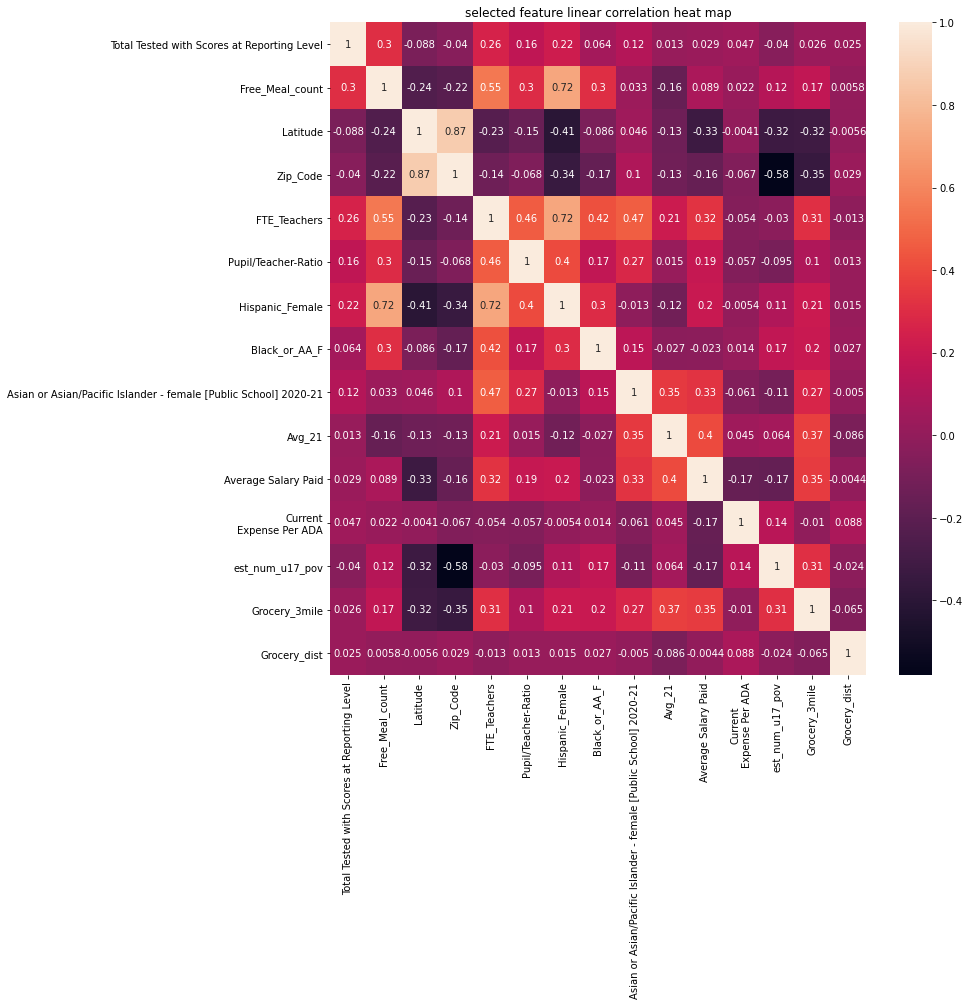

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
fig = sns.heatmap(model_df[vifs].corr(),annot=True)
plt.title('selected feature linear correlation heat map')
plt.show()

## both heat maps show a correlation between free meal count and Hispanic student population 

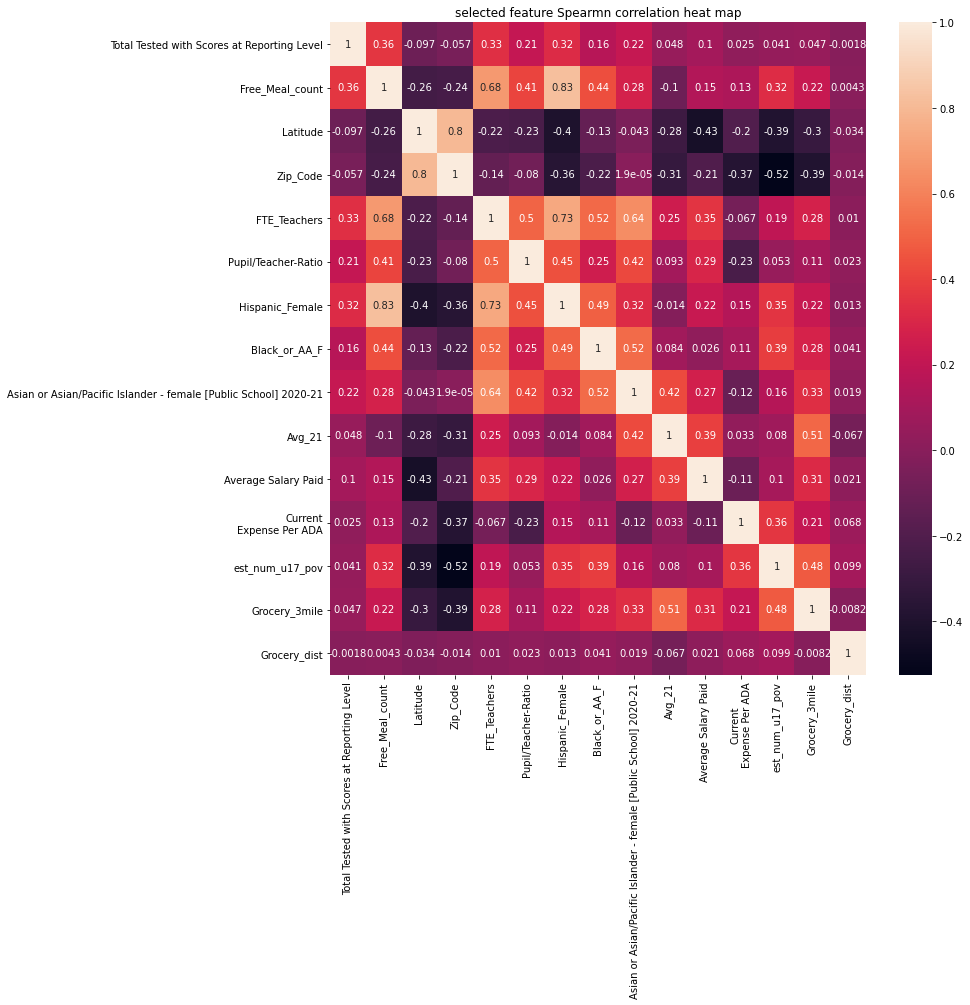

In [32]:
fig, ax = plt.subplots(figsize=(12,12))
fig = sns.heatmap(model_df[vifs].corr(method='spearman'),annot=True)
plt.title('selected feature Spearmn correlation heat map')
plt.show()

# 4
## Use Predictive Power Score package to evaluate feature ability to predict scores

In [44]:
pps.score(model_df,'Avg_21','Mean Scale Score')

{'x': 'Avg_21',
 'y': 'Mean Scale Score',
 'ppscore': 0.18683600858506344,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 61.1901,
 'model_score': 49.75758595107911,
 'model': DecisionTreeRegressor()}

In [45]:
pps.score(model_df,'Latitude','Mean Scale Score')


{'x': 'Latitude',
 'y': 'Mean Scale Score',
 'ppscore': 0.2937313321197931,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 61.1901,
 'model_score': 43.21665041445665,
 'model': DecisionTreeRegressor()}

In [35]:
pps.score(model_df,'Longitude','Mean Scale Score')

{'x': 'Longitude',
 'y': 'Mean Scale Score',
 'ppscore': 0.2877445176873602,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'baseline_score': 61.1901,
 'model_score': 43.58298418825866,
 'model': DecisionTreeRegressor()}

## Latitude has more predive power than longitude and well be kept bewteen the two as both would cause the VIF score to be higher than 5 for each. 

In [46]:
pps = model_df[['Mean Scale Score','Total Tested with Scores at Reporting Level',
 'Free_Meal_count',
 'Latitude',
 'FTE_Teachers',
 'Pupil/Teacher-Ratio',
 'Hispanic_Female',
 'Black_or_AA_F',
 'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
 'Avg_21',
 'Average Salary Paid',
 'Current\nExpense Per ADA',
 'est_num_u17_pov',
 'Grocery_3mile',
 'Grocery_dist']].copy()

In [47]:
df = pd.DataFrame(pps)



## Heat map of pps score for key features 

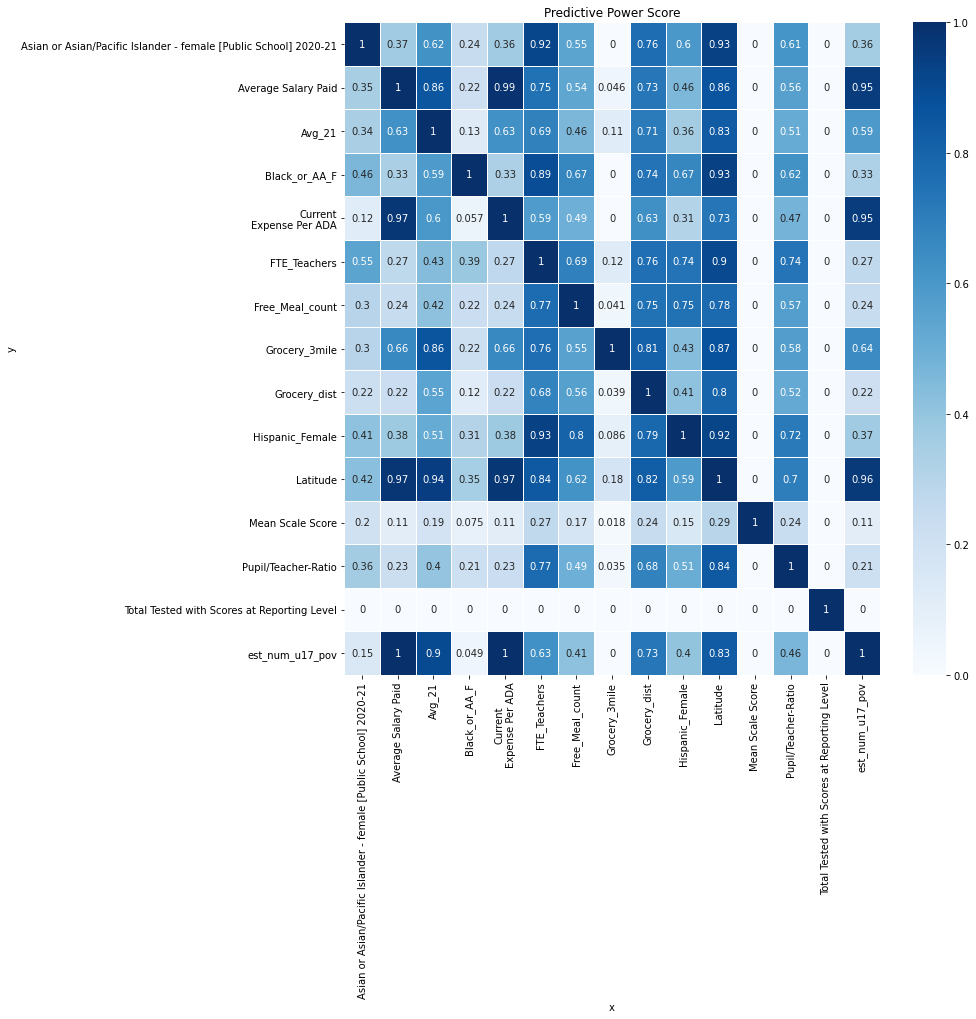

In [53]:
fig, ax = plt.subplots(figsize=(12,12))
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig = sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.title('Predictive Power Score')
plt.show()

## Insight 
- Estimated youth population in poverty estimates the average housing price and distance to the nearest grocery store. The relationship between these features could be an indicator of communities in food deserts where there is a farther distance to a grocery store than in more affluent areas with lower youth poverty and access to food. 

In [ ]:
## Distance to nearest grocery store got a ppscore of .24

In [52]:
pps.predictors(model_df, "Mean Scale Score")

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,Percent_Eligible_Free,Mean Scale Score,0.345851,regression,True,mean absolute error,61.1901,40.027468,DecisionTreeRegressor()
1,Percent_Eligible_FRPM,Mean Scale Score,0.339751,regression,True,mean absolute error,61.1901,40.400675,DecisionTreeRegressor()
2,Percent_Eligible,Mean Scale Score,0.339518,regression,True,mean absolute error,61.1901,40.414933,DecisionTreeRegressor()
3,School_Name,Mean Scale Score,0.332634,regression,True,mean absolute error,61.1901,40.836192,DecisionTreeRegressor()
4,Latitude,Mean Scale Score,0.293731,regression,True,mean absolute error,61.1901,43.216650,DecisionTreeRegressor()
5,Enrollment,Mean Scale Score,0.288604,regression,True,mean absolute error,61.1901,43.530377,DecisionTreeRegressor()
6,Longitude,Mean Scale Score,0.287745,regression,True,mean absolute error,61.1901,43.582984,DecisionTreeRegressor()
7,FTE_Teachers,Mean Scale Score,0.267616,regression,True,mean absolute error,61.1901,44.814681,DecisionTreeRegressor()
8,9-12_Students,Mean Scale Score,0.244752,regression,True,mean absolute error,61.1901,46.213716,DecisionTreeRegressor()
9,Grocery_dist,Mean Scale Score,0.243707,regression,True,mean absolute error,61.1901,46.277653,DecisionTreeRegressor()


In [55]:
final = model_df[[
    'Mean Scale Score','County_Name', 'District_Name', 'School_Name', 
       'Demographic Name', 'Student Group', 'District Type', 'Test ID',
       'School Type', 'Education_type', 'Charter_School', 'Low Grade',
        'Total Tested at Reporting Level',
       'Total Tested with Scores at Reporting Level', 'Students Enrolled',
       'Students Tested', 'Students with Scores', 'Enrollment',
       'Free_Meal_count', 'Percent_Eligible', 'FRPM_Count',
       'Percent_Eligible_FRPM', 'Free_Meal_Count', 'Percent_Eligible_Free',
       'Latitude', 'Longitude', '9-12_Students', 'FTE_Teachers',
       'Pupil/Teacher-Ratio', 'Hispanic_Male', 'Hispanic_Female',
       'Black_or_AA_M', 'Black_or_AA_F',
       'Asian or Asian/Pacific Islander - male [Public School] 2020-21',
       'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
       'Avg_21', 'Total Salary Schedule FTE', 'Lowest Salary Offered',
       'Average Salary Paid', 'Highest Entry Level Step',
       'Highest Salary Offered', 'Salary at BA+60 Step 10', '2020–21 P‑2 ADA',
       '% Salary Change Over 2019–20', 'EDP 365', 'Current\nExpense ADA',
       'Current\nExpense Per ADA', 'Estimated Total Population',
       'Estimated Population 5-17', 'est_num_u17_pov', 'Grocery_3mile',
       'Grocery_dist']]

# Create final DF and save for modeling 

In [26]:
final = model_df[[
    # target
    'Mean Scale Score',
    # labels for rows 
    'County_Name', 'District_Name', 'School_Name', 
    # features 
    'Total Tested with Scores at Reporting Level',
    'Demographic Name', 'Student Group', 'District Type', 'Test ID',
       'School Type', 'Education_type', 'Charter_School', 'Low Grade',
    'Free_Meal_count',
     'Latitude', 
   'FTE_Teachers', 
   'Pupil/Teacher-Ratio', 
       'Hispanic_Female',
        'Black_or_AA_F',
       'Asian or Asian/Pacific Islander - female [Public School] 2020-21',
       'Avg_21',
       'Average Salary Paid', 
       'Current\nExpense Per ADA', 
     'est_num_u17_pov', 
    'Grocery_3mile',
       'Grocery_dist']].copy()

In [28]:
final.to_csv('../../data/model/final_df.csv')

In [29]:
final.shape

(52665, 26)